DSCI100 002, Group 18

Group Members: Jimmy Choy, Jennifer Law, Heather Lu, Elise Wong



**Sleep Disorder Diagnosis**

**Introduction**

Sleep is fundamental to human life and health, but many people suffer from sleep disorders. Two sleep disorders are sleep apnea–where breathing stops during sleep–and insomnia, where people have difficulty falling asleep. Sleep disorders can be influenced by lifestyle and are often comorbid with chronic health disorders. 

In our project, we will utilise the Sleep Health and Lifestyle Dataset, which includes information pertaining to sleep, lifestyle, cardiovascular health, and sleep disorders. We aim to determine: “How can lifestyle and physiological measures be used to determine the absence or presence of sleep disorders?” 

**Methods**

We will predict the diagnosis (sleep disorder or none) via classification as the diagnosis variable is categorical. 
Our model will exclude "Gender", "Occupation" and “BMI category”. We observed imbalanced proportions in these variables, which will introduce bias to the model’s performance. We will also exclude them because they are factor variables. We will restrict our predictors to only numerical variables for consistency in analysis. “Person ID” will also be excluded as it labels each observation and should not be used as a predictor. All other variables will be used as predictors, as they are a diverse set of health factors related to sleep disorders. The "Blood Pressure" variable will be divided into systolic and diastolic variables to ensure that each cell contains one value only.

“Insomnia” and “sleep apnea” will be combined to a single value: “Sleep Disorder” in the Diagnosis column so that the number of subjects with a sleep disorder is similar to the number of subjects without one.

We will split the tidied dataset into a training and testing set. We will use the training set to build our classification model, then use the model to make predictions and compare the outcome to the testing set. Based on the results, we will assess the accuracy of our model. The results will be visualized by plotting the accuracy of our model vs different K values in a line graph. This will help identify the K that yields the highest accuracy. 


**Preliminary exploratory data analysis**

In [14]:
library(tidyverse)
library(tidymodels)
url <- "https://drive.google.com/uc?export=download&id=1oltvINJVaLEg0raTdWG2IoFCf6w4h5vD"
sleep_data <- read_delim(url,
                         delim = ",")
head(sleep_data)

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


In [15]:
#adding a period to replace spaces in the headers
colnames(sleep_data) <- make.names(colnames(sleep_data))

In [16]:
#separating bp column
sleep_data <- separate(sleep_data,
    col = Blood.Pressure,
    into = c("Systolic.BP", "Diastolic.BP"),
    sep = "/",
    convert = TRUE) 

In [17]:
#removing unwanted predictors
sleep_data_2 <- sleep_data |>
    select(-Person.ID, -Gender, -Occupation, -BMI.Category)
head(sleep_data_2)

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Sleep.Disorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
27,6.1,6,42,6,126,83,77,4200,None
28,6.2,6,60,8,125,80,75,10000,None
28,6.2,6,60,8,125,80,75,10000,None
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Insomnia


In [18]:
#combining 'sleep apnea' and 'insomnia' into 'sleep disorders'
sleep_apnea_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Sleep Apnea") |>
select(-Sleep.Disorder)
sleep_apnea_tidy <- data.frame(sleep_apnea_untidy, Diagnosis = "Sleep Disorder")

insomnia_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Insomnia") |>
select(-Sleep.Disorder)
insomnia_tidy <- data.frame(insomnia_untidy, Diagnosis = "Sleep Disorder")

none_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "None") |>
select(-Sleep.Disorder)
none_tidy <- data.frame(none_untidy, Diagnosis = "None")

tidy_sleep_data <- rbind(sleep_apnea_tidy, insomnia_tidy, none_tidy)

head(tidy_sleep_data)

,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Diagnosis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
2,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
3,29,6.5,5,40,7,132,87,80,4000,Sleep Disorder
4,29,6.0,6,30,8,120,80,70,8000,Sleep Disorder
5,30,6.4,5,35,7,130,86,78,4100,Sleep Disorder
6,31,7.7,7,75,6,120,80,70,8000,Sleep Disorder


In [19]:
#splitting the data into training and test sets
sleep_split <- initial_split(tidy_sleep_data, prop = 0.75, strata = Diagnosis)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

**Table 1**

The table below represents the number of observations and percentages for each class in the training set.

In [20]:
summary_table_1 <- sleep_train |>
  group_by(Diagnosis) |>
  summarize(count = n(), percentage = n()/nrow(sleep_train)*100)

summary_table_1

Diagnosis,count,percentage
<chr>,<int>,<dbl>
None,164,58.57143
Sleep Disorder,116,41.42857


**Table 2**

The table below represents the means for each predictor in the training set.

In [21]:
summary_table_2 <- summarize(sleep_train, across(Age:Daily.Steps, mean))
summary_table_2

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.61429,7.153571,7.339286,59.36071,5.414286,128.7714,84.81429,70.13571,6861.429


**Visualization**

Mean stress level (1-10)--where 1 represents lowest stress and 10 represents highest--between those with a sleep disorder diagnosis versus those without, in the training set. We observe that the mean stress level is greater for individuals with a sleep disorder diagnosis compared to those without.

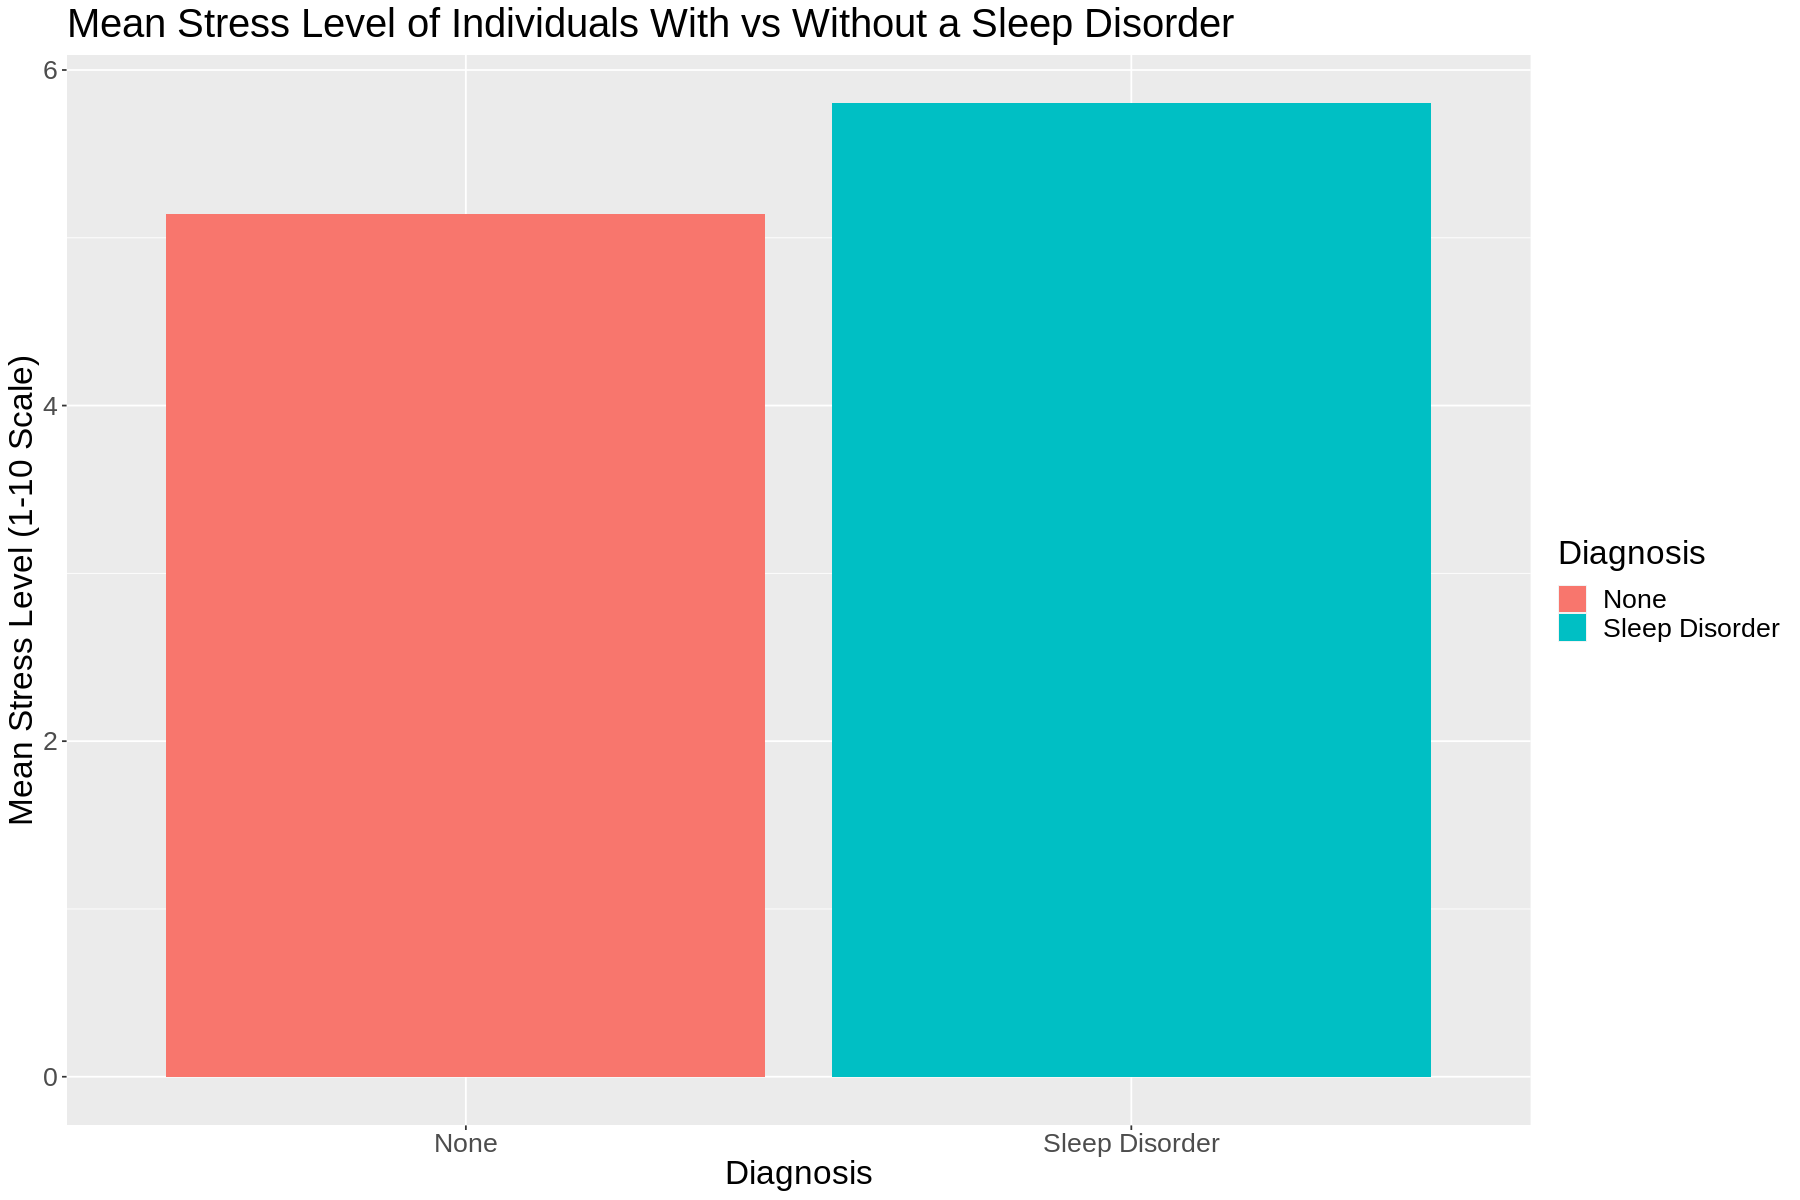

In [22]:
stress_mean <- sleep_train |>
    group_by(Diagnosis) |>
    summarize(Stress = mean(Stress.Level))

options(repr.plot.width = 15, repr.plot.height = 10)

mean_stress_plot <- stress_mean |>
        ggplot(aes(y = Stress, x = Diagnosis, fill = Diagnosis))+
        geom_bar(stat = "identity", position = "dodge")+
        labs(x = "Diagnosis", y = "Mean Stress Level (1-10 Scale)") +
        theme(text = element_text(size = 20)) +
        ggtitle("Mean Stress Level of Individuals With vs Without a Sleep Disorder")
mean_stress_plot  

**Expected outcomes and significance:**

This proposal aims to develop a classification model using physiological measures and lifestyle factors to find the best K parameter for accurate prediction of sleep disorder. It is hypothesised that individuals reporting the shortest sleep duration, lowest levels of physical activity, highest stress levels, and unhealthy physiological measurements will have a higher likelihood of sleep disorder diagnosis. 

**Future questions our project could lead to are:**
- What forms of interventions could be implemented to help the populations most affected by sleep disorders?
- Are there any other factors relating to lifestyle habits that also correlate with sleep disorder diagnosis?


**References**
Tharmalingam, L. (2023, May 26). Sleep health and lifestyle dataset. Kaggle.    https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset 